In [49]:
#Pre-requisition
#!python -m pip install keras
#!python -m pip install --upgrade tensorflow

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sb
sb.set()

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

import warnings
warnings.filterwarnings('ignore')

In [50]:
train = pd.read_csv("../../Data/AAPLTrain.csv",parse_dates=['Date'],index_col=['Date'])
test = pd.read_csv("../../Data/AAPLTest.csv",parse_dates=['Date'],index_col=['Date'])

In [51]:
train = train.loc[lambda x : x.index > dt.datetime(2012,12,31)]
train = train.reset_index()['Adj Close']
scaler = MinMaxScaler(feature_range=(0,1))
df_train = scaler.fit_transform(np.array(train).reshape(-1,1))

In [52]:
n_steps = 30;

In [53]:
def create_dataset(dataset,time_step=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [54]:
x_train, y_train = create_dataset(df_train,n_steps) 

In [55]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)

In [56]:
model = Sequential()
model.add(LSTM(50,return_sequences=True, activation='relu',input_shape=(n_steps,1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [57]:
history = model.fit(x_train,y_train, epochs=50,validation_data=(x_train,y_train),shuffle=False,verbose=False)

In [58]:
prediction_list = []
last_x = x_train[-1]
while len(prediction_list) < len(test):
    p = model.predict(last_x.reshape(1,n_steps,1))[0,0]

    prediction_list.append(p)
    last_x = np.roll(last_x,-1)
    last_x[-1] = p

prediction_list = scaler.inverse_transform(prediction_list)
test['Prediction'] = prediction_list

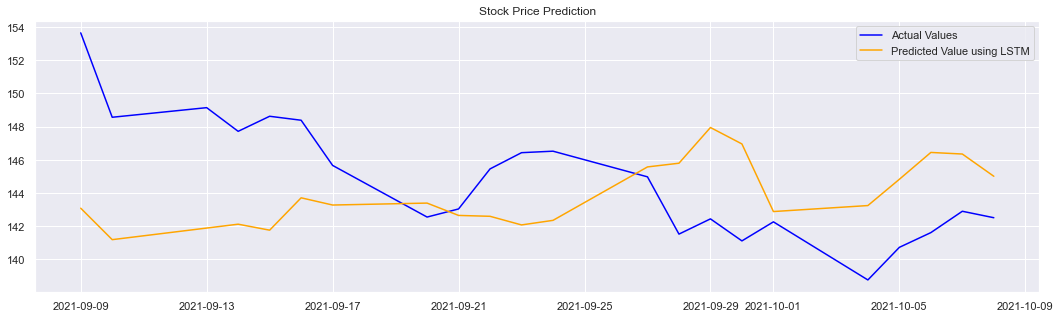

In [59]:
fig = plt.figure(figsize=(18,5))
plt.plot(test['Adj Close'], color="blue",label="Actual Values")
plt.plot(test['Prediction'], color="orange",label="Predicted Value using LSTM")
plt.title("Stock Price Prediction")
plt.legend()